In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import gc
from tqdm import tqdm
import time
from datetime import datetime
import datetime as dt
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
import random
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score,f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU,LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [2]:
change_ratio = 1.5

In [3]:
TRAIN_OR_INFERENCE = 'INFERENCE'

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
tqdm.pandas()

In [5]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [7]:
seed_everything(seed=51)

In [8]:
def timer_decorator(function_to_call):
    def wrapper(*args,**kwargs):
        time_before = datetime.now()
        value_to_return =  function_to_call(*args,**kwargs)
        time_after = datetime.now()
        print(f"data elapsed = {time_after - time_before}")
        return value_to_return
    return wrapper

In [9]:
@timer_decorator
def read_data(path):
    df = pd.read_csv(path)
    print("========")
    print(f"Shape of data = {df.shape}")
    print("========")
    print("Column types are:")
    print(df.dtypes)
    print("========")
    print("Take a glance at data")
    print(pd.concat([df.head(),df.tail()],axis=0))
    print("========")
    return df

In [10]:
data = read_data('15mindata.csv')

Shape of data = (350688, 2)
Column types are:
time     object
open    float64
dtype: object
Take a glance at data
                       time      open
0       2012-01-01 00:00:00      4.58
1       2012-01-01 00:15:00      4.58
2       2012-01-01 00:30:00      4.58
3       2012-01-01 00:45:00      4.58
4       2012-01-01 01:00:00      4.58
350683  2021-12-31 22:45:00  46290.58
350684  2021-12-31 23:00:00  46303.98
350685  2021-12-31 23:15:00  46429.65
350686  2021-12-31 23:30:00  46350.44
350687  2021-12-31 23:45:00  46465.54
data elapsed = 0:00:00.203824


In [11]:
def copy_data(df):
    return df.copy()

In [12]:
@timer_decorator
def create_date_columns(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    return df

In [13]:
#data = create_date_columns(data)

In [14]:
@timer_decorator
def filter_data(df,drop_years, hour_to_keep, minute_to_keep):
    filter_ = (~df['year'].isin(drop_years)) & (df['hour'] % hour_to_keep == 0) & (df['minute'] == 0)
    return df[filter_]

In [15]:
#data = filter_data(data,[2012],4,0)

# Set Parameters

In [16]:
time_step = 120
next_period = 1
n_features = 1

In [17]:
@timer_decorator
def create_train_data(df,time_step,next_period):
    arr = np.array(df['open'])
    input_data = []
    target_data = []
    for i in tqdm(range(len(arr) - time_step)):
        input_data.append(arr[i:i+time_step])
        target_data.append(arr[i+time_step])
    input_data = np.asarray(input_data)
    target_data = np.asarray(target_data)
    mydata = pd.DataFrame(input_data,columns = ['T{}'.format(i) for i in range(1,time_step + 1,1)])
    mydata['target'] = target_data
    
    print(f"Training data size =  {mydata.shape}")
    
    return mydata

In [18]:
#data = create_train_data(data,time_step,next_period)

In [19]:
def label_maker(x):
    if x <= -1.5:
        return 0
    elif (-1.5 < x) & (x <= 1.5):
        return 1
    elif 1.5 < x :
        return 2
    else:
        pass

In [20]:
@timer_decorator
def create_label(df):
    df['scaled_target'] = (df.iloc[:,-1] - df.iloc[:,-2]) / df.iloc[:,-2]
    df['percentile_target'] = df['scaled_target']*100
    df['categorical_target_change'] = (df['percentile_target'].abs() > change_ratio) *1
    return df

In [21]:
#data = create_label(data)

In [22]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [23]:
@timer_decorator
def create_columnwise_features(df,time_step):
    df['columnwise_min'] = df.iloc[:,:time_step].min(axis=1)
    df['columnwise_max'] = df.iloc[:,:time_step].max(axis=1)
    df['columnwise_median'] = df.iloc[:,:time_step].median(axis=1)
    return df

In [24]:
#data = create_columnwise_features(data,time_step)

In [25]:
def scale_btw_neg1_and_pos1(df,time_step):
    df[[f'T{x}' for x in range (1,time_step+1,1) ]] = \
    np.array([ np.interp( x, ( np.array(x).min(),np.array(x).max() ), (-1,1) )\
              for x in df[[f'T{x}' for x in range (1,time_step+1,1) ]].values.tolist() ])
    return df

In [26]:
def scale_btw_0_and_1(df,time_step):
    for i in range(1,time_step+1,1):
        df['T{}'.format(i)] = (df['T{}'.format(i)] - df['columnwise_min']) / (df['columnwise_max'] - df['columnwise_min'])
    return df

In [27]:
#data = scale_btw_0_and_1(data,time_step)

In [28]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [29]:
def create_input_via_shifting(df, time_step):
    print(df.shape)
    for i in range(1,time_step+1,1):
        df['T{}'.format(time_step + 1 - i)] = df['categorical_target_change'].shift(i)
    
    df = df[time_step:].reset_index(drop=True)
    print(df.shape)
    return df

In [30]:
#data = create_input_via_shifting(data, time_step)

In [31]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [32]:
#mydata['categorical_target'].value_counts(normalize=True)

In [33]:
data.head()

,time,open
0,2012-01-01 00:00:00,4.58
1,2012-01-01 00:15:00,4.58
2,2012-01-01 00:30:00,4.58
3,2012-01-01 00:45:00,4.58
4,2012-01-01 01:00:00,4.58


In [34]:
data = (data.pipe(copy_data)
     .pipe(create_date_columns)
     .pipe(filter_data,drop_years = [2012],hour_to_keep = 4,minute_to_keep = 0)
     .pipe(create_train_data,time_step,next_period)
     .pipe(create_label)
     .pipe(create_input_via_shifting,time_step)
)

data elapsed = 0:00:00.211102
data elapsed = 0:00:00.015633


100%|████████████████████████████████| 19602/19602 [00:00<00:00, 1582034.42it/s]

Training data size =  (19602, 121)
data elapsed = 0:00:00.026135
data elapsed = 0:00:00.002190
(19602, 124)
(19482, 124)


In [35]:
data.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,scaled_target,percentile_target,categorical_target_change
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,23.13,-0.005161,-0.516129,0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,23.49,0.015564,1.556420,1
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,23.16,-0.014049,-1.404853,0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,23.46,0.012953,1.295337,0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,23.07,-0.016624,-1.662404,1


# Create Train, Test, Valid

In [36]:
data['categorical_target_change'].value_counts(normalize=True)

0    0.784416
1    0.215584
Name: categorical_target_change, dtype: float64

In [37]:
def create_train_valid_test(df,time_step,train_ratio=0.7,valid_ratio=0.15):
    train_border = train_ratio
    valid_border = train_border + valid_ratio
    
    X_train = df[['T{}'.format(t) for t in range(1,time_step +1,1) ]][:int(len(df)*train_border)].values
    X_val = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*train_border):int(len(df)*valid_border)].values
    X_test = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*valid_border):].values
    
    y_train = df['categorical_target_change'][:int(len(df)*train_border)]
    y_val = df['categorical_target_change'][int(len(df)*train_border):int(len(df)*valid_border)]
    y_test = df['categorical_target_change'][int(len(df)*valid_border):]
    
    print(f"Train size = {len(X_train)}; Valid size = {len(X_val)}; Test size = {len(X_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [38]:
X_train, X_val , X_test, y_train, y_val, y_test = create_train_valid_test(data, time_step)

Train size = 13637; Valid size = 2922; Test size = 2923


# Create weights of classes inproportional to percentages

In [39]:
def create_weights(series):
    print("Class Distributions are ")
    print(series.value_counts(normalize=True))
    weight_dict= {x[0]: 1/x[1]  for x in series.value_counts(normalize=True).to_dict().items()}
    return weight_dict

In [40]:
weight_dict = create_weights(y_train)

Class Distributions are 
0    0.786903
1    0.213097
Name: categorical_target_change, dtype: float64


# Oversampling data

In [41]:
from imblearn.over_sampling import SMOTE
def oversample_train(X,y):
    X,y = shuffle(X,y,random_state=60)
    smote = SMOTE(random_state=51)
    X,y = smote.fit_resample(X,y)
    print(X.shape,y.shape)
    return X,y

In [42]:
#X_train, y_train = oversample_train(X_train, y_train)

# Dummifacation of Target

In [43]:
def dummify_y_columns(training_y,valid_y,test_y):
    training_y = pd.get_dummies(training_y)
    valid_y = pd.get_dummies(valid_y)
    test_y = pd.get_dummies(test_y)
    print(f"Shapes after dummification in train, valid, test order = [{training_y.shape,valid_y.shape, test_y.shape}]")
    return training_y, valid_y, test_y

In [44]:
# y_train, y_val, y_test = dummify_y_columns(y_train, y_val, y_test)

# Resape Input for LSTM's

In [45]:
def reshape_input(training_X, valid_X, test_X, n_features):
    training_X = training_X.reshape((training_X.shape[0], training_X.shape[1], n_features))
    valid_X = valid_X.reshape((valid_X.shape[0], valid_X.shape[1], n_features))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
    print(f"Shapes after reshaping are in order [{training_X.shape},{valid_X.shape}, {test_X.shape}]")
    return training_X, valid_X, test_X

In [46]:
X_train, X_val, X_test = reshape_input(X_train, X_val, X_test, n_features)

Shapes after reshaping are in order [(13637, 120, 1),(2922, 120, 1), (2923, 120, 1)]


# Shuffle Data

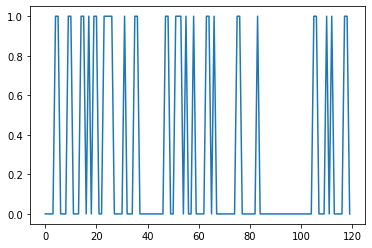

In [47]:
plt.plot(X_train[0])
plt.show()

In [48]:
X_train, y_train = shuffle(X_train,y_train,random_state=60)

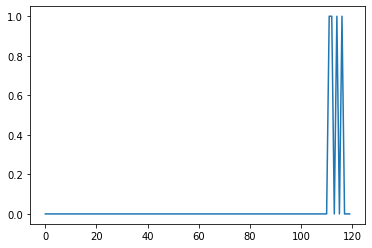

In [49]:
plt.plot(X_train[0])
plt.show()

# Fill Input with noise

In [50]:
def fill_input_with_noise(training_X):
    training_X = np.random.rand(training_X.shape[0],training_X.shape[1],training_X.shape[2])
    return training_X

In [51]:
#X_train = fill_input_with_noise(X_train)

# Defining model

In [52]:
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.05, patience=5 )

In [53]:
def create_LSTM_model(time_step, n_features):
    tf.keras.backend.clear_session()
    model = Sequential()
    model = Sequential()
    model.add(GRU(256, activation='tanh', input_shape=(time_step, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-4), metrics=[tf.keras.metrics.AUC(),'accuracy'])
    return model

In [54]:
model = create_LSTM_model(time_step, n_features)

2022-09-09 18:17:57.194866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:17:57.251904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:17:57.252248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:17:57.253737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [55]:
def create_MLP_model(X_train):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(1024,activation='relu',input_shape = (X_train.shape[1],)))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

In [56]:
# model = create_MLP_model()

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               198912    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 231,937
Trainable params: 231,937
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, y_train, epochs =15 , validation_data = (X_val,y_val) ,batch_size = 8, callbacks=[reduce_lr])

Epoch 1/15


2022-09-09 18:18:02.825446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1705/1705 [==============================] - 19s 10ms/step - loss: 0.4560 - auc: 0.7426 - accuracy: 0.7968 - val_loss: 0.4323 - val_auc: 0.6776 - val_accuracy: 0.8244 - lr: 1.0000e-04
Epoch 2/15
1705/1705 [==============================] - 17s 10ms/step - loss: 0.4381 - auc: 0.7690 - accuracy: 0.8006 - val_loss: 0.4343 - val_auc: 0.6787 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 3/15
1705/1705 [==============================] - 17s 10ms/step - loss: 0.4372 - auc: 0.7706 - accuracy: 0.8005 - val_loss: 0.4442 - val_auc: 0.6753 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 4/15
1705/1705 [==============================] - 16s 9ms/step - loss: 0.4364 - auc: 0.7724 - accuracy: 0.8008 - val_loss: 0.4358 - val_auc: 0.6756 - val_accuracy: 0.8258 - lr: 1.0000e-04
Epoch 5/15
1705/1705 [==============================] - 17s 10ms/step - loss: 0.4368 - auc: 0.7702 - accuracy: 0.8030 - val_loss: 0.4331 - val_auc: 0.6780 - val_accuracy: 0.8251 - lr: 1.0000e-04
Epoch 6/15
1705/1705 [===============

In [59]:
model.save('model.h5')

# Train

In [60]:
y_train_predicted = model.predict(X_train)[:,0]

In [61]:
def plot_prediction_and_auc(predictions,true_values):
    plt.hist(predictions,bins=50, label = "Class 0")
    plt.legend()
    plt.show()
    
    print("AUC = {}".format(roc_auc_score(true_values,predictions)))
    
    fpr, tpr, _ = roc_curve(true_values,  predictions)
    auc = roc_auc_score(true_values, predictions)
    plt.plot(fpr,tpr,label="train, auc="+str(auc))
    plt.plot([0,1],[0,1])
    plt.legend(loc=4)
    plt.show()

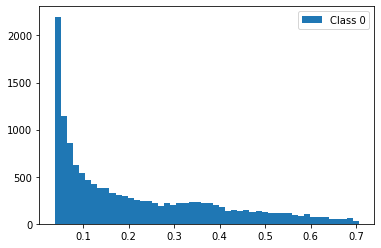

AUC = 0.7831345890042184


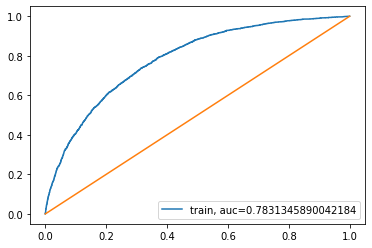

In [62]:
plot_prediction_and_auc(y_train_predicted,y_train)

# Val

In [63]:
y_val_predicted = model.predict(X_val)[:,0]

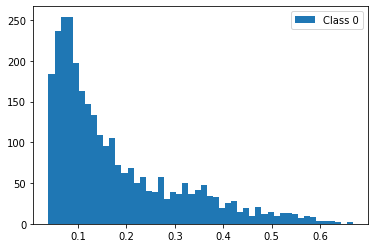

AUC = 0.6854619338439379


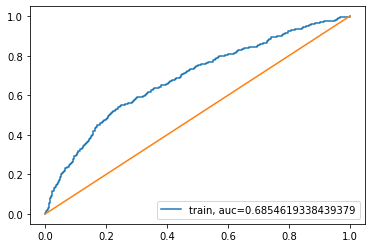

In [64]:
plot_prediction_and_auc(y_val_predicted,y_val)

In [65]:
def plot_precision_recall_f1(preds,truth):
    f1_list = []
    precision_list = []
    recall_list = []
    for i in np.arange(0.01,1.0,0.01):
        preds_converted = (preds >= i)*1
        
        f1_list.append( f1_score(truth,preds_converted) )
        precision_list.append( precision_score(truth,preds_converted,zero_division=0) )
        recall_list.append( recall_score(truth,preds_converted) )
    
    stats_data = pd.concat( [pd.Series(f1_list,name='f1'),pd.Series(precision_list,name='precision'),pd.Series(recall_list,name='recall')] , axis=1 )
    stats_data.index = np.arange(0.01,1.0,0.01)
    
    plt.plot(stats_data['f1'],label='f1')
    plt.plot(stats_data['precision'],label='precision')
    plt.plot(stats_data['recall'],label='recall')
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend()
    plt.show()

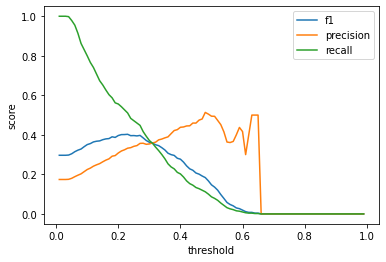

In [66]:
plot_precision_recall_f1(y_val_predicted,y_val)

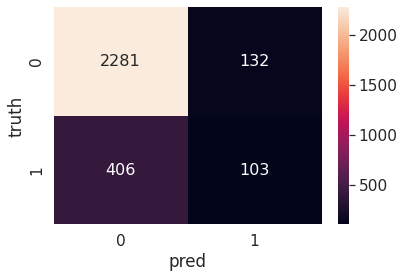

In [67]:
y_val_predicted_class = (y_val_predicted > 0.40) * 1

val_cm = confusion_matrix(y_val,y_val_predicted_class)

df_cm = pd.DataFrame(val_cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('pred')
plt.ylabel('truth')
plt.show()

# Test

In [68]:
y_test_predicted = model.predict(X_test)

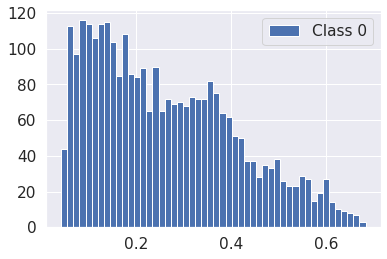

AUC = 0.6648728200056009


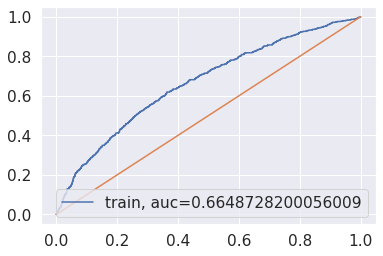

In [69]:
plot_prediction_and_auc(y_test_predicted[:,0],y_test)

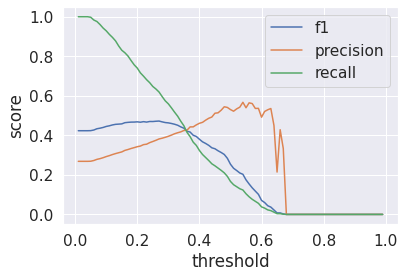

In [70]:
plot_precision_recall_f1(y_test_predicted,y_test)

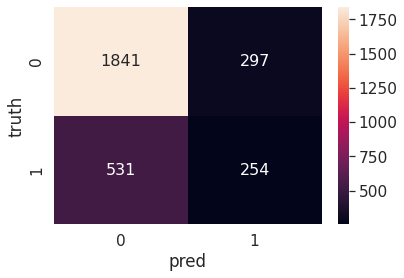

In [71]:
y_test_predicted_class = (y_test_predicted > 0.40) * 1

val_test = confusion_matrix(y_test,y_test_predicted_class)

df_cm = pd.DataFrame(val_test, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('pred')
plt.ylabel('truth')
plt.show()

In [72]:
data.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

True